# Contents

I. Train and Test Data Loading

II. Model Definition & Training


## 라이브러리 import

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.1 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.model_selection import train_test_split

# 1. Data Loading

In [ ]:
# mount our Google Drive into the Colab environment
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os

root_dir = "/content/gdrive/MyDrive/Data Science Team Project" # Please put your directory here

# Checking if our specified directory exists
os.path.exists(root_dir)

True

In [ ]:
# Specify the file name
train_file = "Data1_Train.csv"

# Load the dataset using pandas
train_set = pd.read_csv(os.path.join(root_dir, train_file))

### train val set split

In [ ]:
# 'YEAR_SINCE_2000' 컬럼 기준으로 스플릿
train_df = train_set[train_set['YEAR_SINCE_2000'] <= 14].reset_index(drop=True)
val_df   = train_set[train_set['YEAR_SINCE_2000'] >= 15].reset_index(drop=True)

# 결과 확인 (행 수 출력)
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# 필요시 저장
# train_set.to_csv("train_set.csv", index=False)
# val_set.to_csv("val_set.csv", index=False)

Train set size: 720
Validation set size: 60


### input, target 정의

In [ ]:
# 입력 컬럼: 'YEAR' + 'MONTH_1' ~ 'MONTH_12'
month_cols = [col for col in train_df.columns if col.startswith("MONTH_")]
input_cols = ['YEAR_SINCE_2000'] + month_cols + ['LINEAR_TEMP_TREND'] + ['YEAR_MONTH_INDEX'] + ['YEAR_SQUARED']

# 타겟 컬럼 정의
target_cols = ['MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'temp_range', 'daily_precip']

# X, y 생성
X_train = train_df[input_cols]
y_train = train_df[target_cols]
X_val   = val_df[input_cols]
y_val   = val_df[target_cols]

### test set

In [ ]:
test_file = "Data1_Test.csv"
test_set = pd.read_csv(os.path.join(root_dir, test_file))

# X_test, y_test로 분리
X_test = test_set[input_cols]
y_test = test_set[target_cols]

### full train

In [ ]:
# Full dataset by combining training and validation sets
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

# 2. Model Definition & Training

### 1. 모델 구조: **StackingRegressor**

- **Base 모델**
    - `CatBoost`: 전체 타깃에 대해 **하이퍼파라미터 통일**
    - `LinearRegression`: 타깃 변수별로 **개별 학습**
- **Meta 모델**
    - `RidgeCV` 사용 (과적합 방지 및 자동 튜닝)


In [ ]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import StackingRegressor

# Optuna objective function
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': 42,
        'verbose': 0,
    }

    # Train and predict for each target variable
    val_preds = []
    for target in target_cols:
        # CatBoost model
        cb = CatBoostRegressor(**params)

        # Base models: common CatBoost + individual LinearRegression
        base_models = [
            ('catboost', cb),
            ('linear', LinearRegression())
        ]
        meta_model = RidgeCV()

        stack = StackingRegressor(estimators=base_models, final_estimator=meta_model)
        stack.fit(X_train, y_train[target])
        val_pred = stack.predict(X_val)
        val_preds.append(val_pred)

    # # Calculate mean MAE across all targets
    val_preds = np.array(val_preds).T  # (samples, targets)
    mae = np.mean([mean_absolute_error(y_val[col], val_preds[:, i]) for i, col in enumerate(target_cols)])
    return mae

# Optuna로 파라미터 튜닝
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적 파라미터 고정
best_params = study.best_params
best_params.update({'random_seed': 42, 'verbose': 0})

# 3. Evaluation

In [ ]:
# Define evaluation function
def evaluate(true, pred, dataset_name):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = mse ** 0.5
    r2 = r2_score(true, pred)

    adjusted_r2 = 1 - r2  # Convert to a reversed metric for consistency

    print(f"📊 [{dataset_name} 성능 평가]")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f} (그래프에선 1 - R² = {adjusted_r2:.4f})\n")

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        '1 - R²': adjusted_r2
    }


# Define evaluation function for multiple targets
def evaluate_all_targets(y_true_df, y_pred_array, target_cols, dataset_name="Validation"):
    results = {}
    for i, target in enumerate(target_cols):
        y_true = y_true_df[target]
        y_pred = y_pred_array[:, i]
        print(f"== {target} ==")
        results[target] = evaluate(y_true, y_pred, f"{dataset_name} - {target}")
    return results

### best_params 불러오기

In [ ]:
import joblib

# 저장된 모델 불러오기
save_path = '/content/gdrive/MyDrive/Data Science Team Project/stacking_catboost_model.pkl'
final_model = joblib.load(save_path)

# final_model은 MultiOutputRegressor 타입이고, 내부에 estimators_ 리스트가 있음
target_models = final_model.estimators_  # 리스트: 각 타겟별 StackingRegressor 모델

# 각 타겟별 모델에서 CatBoostRegressor 추출하고 best_params 확인하기
for i, stack_model in enumerate(target_models):
    print(f"--- Target {i} ---")

    # stack_model은 StackingRegressor
    # estimators는 [('catboost', CatBoostRegressor), ('linear', LinearRegression)] 형태 리스트
    for name, estimator in stack_model.estimators:
        if name == 'catboost':
            cb_model = estimator
            print("CatBoost best_params:")
            print(cb_model.get_params())  # CatBoost 모델 파라미터 출력
            # 만약 실제 튜닝 결과만 따로 저장했다면 .get_all_params() 등도 시도 가능

--- Target 0 ---
CatBoost best_params:
{'iterations': 1115, 'learning_rate': 0.011380491982585166, 'depth': 9, 'l2_leaf_reg': 8.165149514401003, 'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 0}
--- Target 1 ---
CatBoost best_params:
{'iterations': 1115, 'learning_rate': 0.011380491982585166, 'depth': 9, 'l2_leaf_reg': 8.165149514401003, 'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 0}
--- Target 2 ---
CatBoost best_params:
{'iterations': 1115, 'learning_rate': 0.011380491982585166, 'depth': 9, 'l2_leaf_reg': 8.165149514401003, 'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 0}
--- Target 3 ---
CatBoost best_params:
{'iterations': 1115, 'learning_rate': 0.011380491982585166, 'depth': 9, 'l2_leaf_reg': 8.165149514401003, 'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 0}
--- Target 4 ---
CatBoost best_params:
{'iterations': 1115, 'learning_rate': 0.011380491982585166, 'depth': 9, 'l2_leaf_reg': 8.165149514401003, 'loss_function': 'RMSE', 'random_seed': 42,

### 3. 모델 재학습

In [ ]:
from sklearn.linear_model import LinearRegression, RidgeCV
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor

best_params = {
    'iterations': 1115,
    'learning_rate': 0.011380491982585166,
    'depth': 9,
    'l2_leaf_reg': 8.165149514401003,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 0
}

# Predict on the test set
test_preds = []

cb = CatBoostRegressor(**best_params)

# Define stacking model
base_models = [
    ('catboost', cb),
    ('linear', LinearRegression())
]
meta_model = RidgeCV()
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)


multioutput_model = MultiOutputRegressor(stacking_model)
multioutput_model.fit(X_full_train, y_full_train)

test_preds = multioutput_model.predict(X_test) # Shape: (n_samples, n_targets)
test_results = evaluate_all_targets(y_test, test_preds, target_cols, dataset_name="Test")

== MAX_TEMP ==
📊 [Test - MAX_TEMP 성능 평가]
MAE : 1.1548
MSE : 2.2610
RMSE: 1.5036
R²  : 0.9701 (그래프에선 1 - R² = 0.0299)

== MIN_TEMP ==
📊 [Test - MIN_TEMP 성능 평가]
MAE : 1.0940
MSE : 2.0284
RMSE: 1.4242
R²  : 0.9776 (그래프에선 1 - R² = 0.0224)

== AVG_WIND_SPEED ==
📊 [Test - AVG_WIND_SPEED 성능 평가]
MAE : 0.1914
MSE : 0.0590
RMSE: 0.2428
R²  : 0.5740 (그래프에선 1 - R² = 0.4260)

== temp_range ==
📊 [Test - temp_range 성능 평가]
MAE : 0.8424
MSE : 1.0727
RMSE: 1.0357
R²  : 0.7036 (그래프에선 1 - R² = 0.2964)

== daily_precip ==
📊 [Test - daily_precip 성능 평가]
MAE : 1.5228
MSE : 4.1469
RMSE: 2.0364
R²  : 0.5937 (그래프에선 1 - R² = 0.4063)



### 시각화

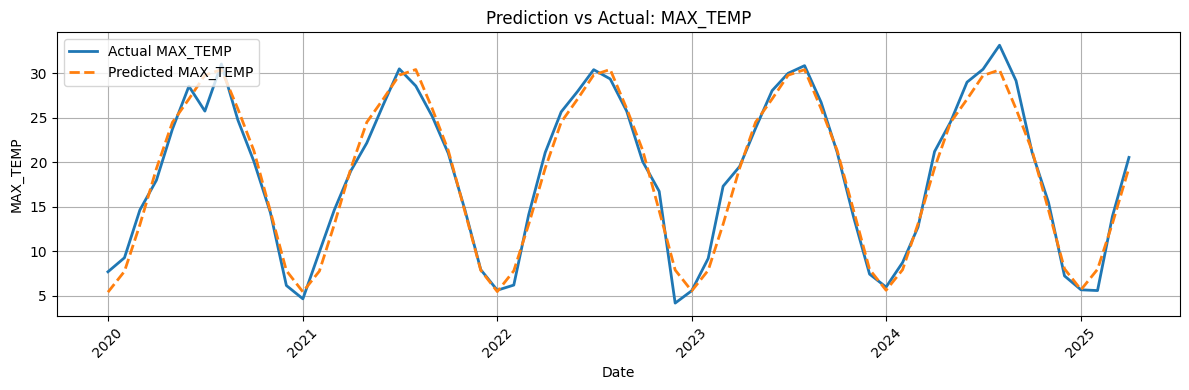

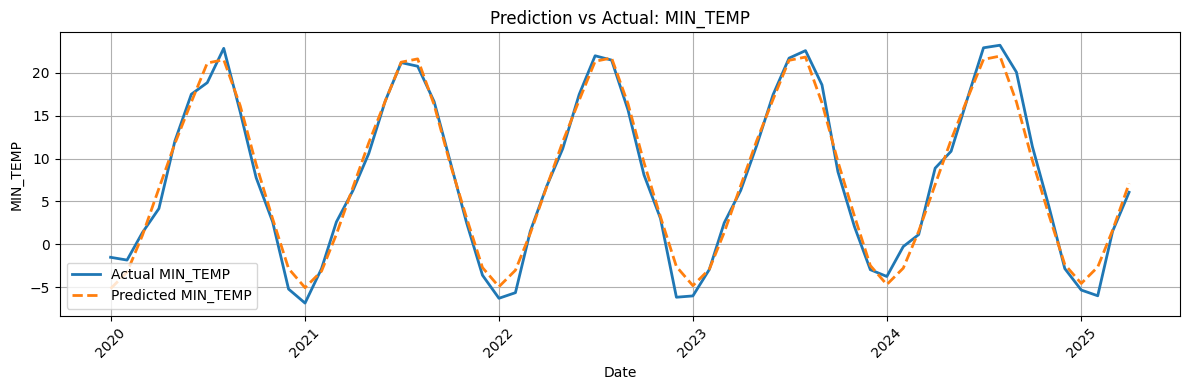

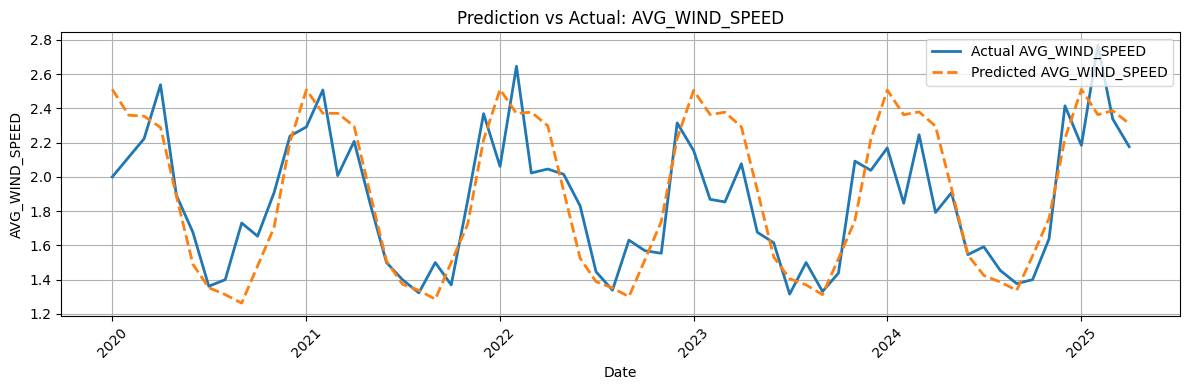

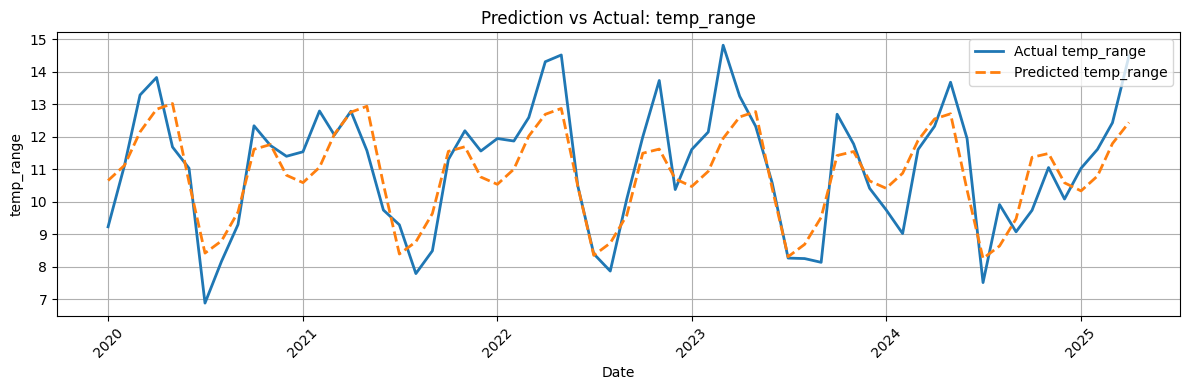

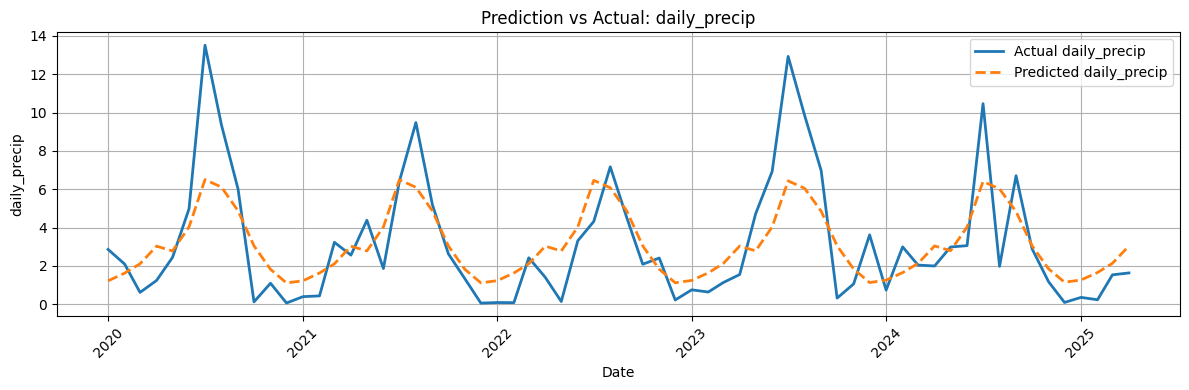

In [ ]:
import matplotlib.pyplot as plt

# 타겟 컬럼들
target_cols = ['MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'temp_range', 'daily_precip']

# test_set 복사본 생성 (원본 보호)
test_df = test_set.copy()

# 원핫 인코딩된 MONTH 컬럼 → 정수형 MONTH 컬럼으로 복원
test_df['MONTH'] = test_df[[f'MONTH_{i}' for i in range(1, 13)]].idxmax(axis=1).str.extract('(\d+)').astype(int)

# 'YEAR_SINCE_2000' 문자열 → datetime 변환 → 시간 순 정렬 기준 생성
test_df['DATE'] = pd.to_datetime((test_df['YEAR_SINCE_2000'] + 2000).astype(str) + '-' + test_df['MONTH'].astype(str) + '-01')
test_df_sorted = test_df.sort_values('DATE').reset_index(drop=True)

# y_test, y_pred도 test_df_sorted와 동일한 인덱스로 재정렬
y_test_sorted = y_test.loc[test_df_sorted.index].reset_index(drop=True)
y_pred_df = pd.DataFrame(test_preds, columns=target_cols)
y_pred_sorted = y_pred_df.loc[test_df_sorted.index].reset_index(drop=True)

# 시각화 설정
plt.rcParams['figure.figsize'] = (12, 4)

# 타겟별 실제값 vs 예측값 시각화
for col in target_cols:
    plt.figure()
    plt.plot(test_df_sorted['DATE'], y_test_sorted[col], label=f'Actual {col}', linewidth=2)
    plt.plot(test_df_sorted['DATE'], y_pred_sorted[col], label=f'Predicted {col}', linestyle='--', linewidth=2)
    plt.title(f'Prediction vs Actual: {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 정리: 정수형 MONTH 컬럼 제거 (있을 경우만)
test_df.drop(columns=['MONTH'], errors='ignore', inplace=True)


### 4. 모델 저장

- `MultiOutputRegressor`로 묶어서 전체 모델을 **하나의 객체로 저장**
- 저장 경로: 드라이브
- 저장 파일명: 'stacking_catboost_model.pkl'

In [ ]:
import os
import joblib

# 최종 학습용으로 모두 합치기
X_full = np.concatenate([X_full_train, X_test], axis=0)
y_full = np.concatenate([y_full_train, y_test], axis=0)

final_model = MultiOutputRegressor(stacking_model)

# 전체 데이터로 학습
final_model.fit(X_full, y_full)

# 모델 저장
save_path = '/content/gdrive/MyDrive/Data Science Team Project/final_stacking_catboost_model.pkl'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
joblib.dump(final_model, save_path)
print(f"최종 모델이 저장되었습니다: {save_path}")

최종 모델이 저장되었습니다: /content/gdrive/MyDrive/Data Science Team Project/final_stacking_catboost_model.pkl
